In [34]:
#------------------------------------------------------------------------------
# -------Support-------
import sys
import os
import os.path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image
import random
from pathlib import Path
import shutil
# -------Image preprocessing-------
import skimage
import skimage.io
import skimage.transform


# -------Neural Networks Support-------
import scipy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# -------Neural Networks Main-------
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D)
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, SGD
from keras.applications import ResNet50
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
import tensorflow as tf
#------------------------------------------------------------------------------

In [2]:
# ------Connection to google drive-----------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# -----------Constants-----------
RANDOM_SEED = 1234
ROOT_DIR = 'drive/MyDrive/data/archive/all/All/'
LABELS = ('Healthy', 'Pneumonia')
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [4]:
# -----------Making results reproducable-----------
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
# ----------Load data and printing statisctics--------------
df = pd.read_csv(ROOT_DIR + 'GTruth.csv')
print(df.head())
print(df.info())

          Id  Ground_Truth
0  643781546             1
1  540270208             0
2  585452583             1
3  341665171             0
4  940983956             1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Id            5856 non-null   int64
 1   Ground_Truth  5856 non-null   int64
dtypes: int64(2)
memory usage: 91.6 KB
None


(4273, 1583)


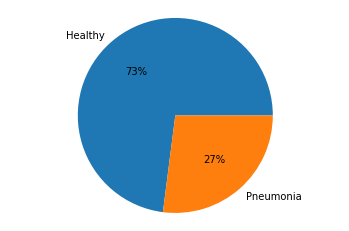

In [6]:
# ----------Printing some metrics about data----------
counts = (
    np.count_nonzero(df['Ground_Truth']),
    np.count_nonzero(df['Ground_Truth'] == 0)
    )
print(counts)

plt.pie(counts, labels=LABELS, autopct='%1.f%%')
plt.axis('equal')
plt.show()

Filename:  668965334.jpeg  Result:  1
Filename:  676847483.jpeg  Result:  1
Filename:  677279569.jpeg  Result:  1
Filename:  679480495.jpeg  Result:  1
Filename:  674666723.jpeg  Result:  1
Filename:  668356357.jpeg  Result:  1
Filename:  686800246.jpeg  Result:  1
Filename:  686753660.jpeg  Result:  1
Filename:  681686270.jpeg  Result:  1


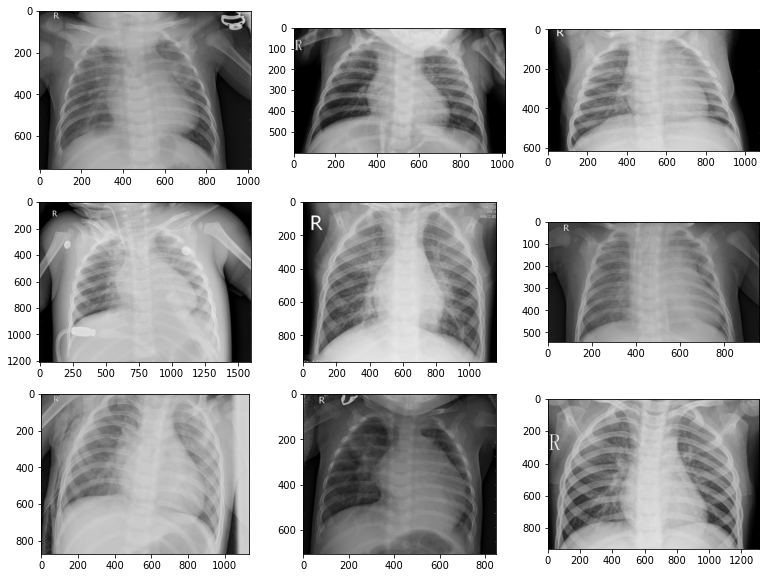

In [7]:
#  ----------Plotting images----------
max_number = 10
images_list = os.listdir(ROOT_DIR)
sample_of_images = [(file_name, image.imread(ROOT_DIR + file_name))
  for i, file_name in enumerate(images_list)
  if (file_name.endswith('.jpeg') or file_name.endswith('.jpg')) 
  and len(images_list) // 2 < i <  len(images_list) // 2 + max_number
]

rows_number, columns_number = 3, 3
fig = plt.figure(figsize=(10,10))
for i, img in enumerate(sample_of_images):
  print('Filename: ', img[0], ' Result: ', 
        df.loc[df['Id'] == int(img[0].split('.')[0]),'Ground_Truth'].values[0])
  
  fig.add_subplot(rows_number, columns_number, i + 1)
  plt.imshow(img[1], cmap=plt.cm.gray)

plt.subplots_adjust(left=1, right=2)
plt.show()

In [8]:
data_dir = 'drive/MyDrive/data/PneumoniaClassification'

try:
  os.mkdir(data_dir)
except FileExistsError:
  shutil.rmtree(data_dir)
  os.mkdir(data_dir)


train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')



try:
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)
except FileExistsError:
    pass

train_1_dir = os.path.join(train_dir, 'healthy')
train_0_dir = os.path.join(train_dir, 'pneumonia')
validation_1_dir = os.path.join(validation_dir, 'healthy')
validation_0_dir = os.path.join(validation_dir, 'pneumonia')
test_1_dir = os.path.join(test_dir, 'healthy')
test_0_dir = os.path.join(test_dir, 'pneumonia')

try:
    os.mkdir(train_1_dir)
    os.mkdir(train_0_dir)
    os.mkdir(validation_1_dir)
    os.mkdir(validation_0_dir)
    os.mkdir(test_1_dir)
    os.mkdir(test_0_dir)
except FileExistsError:
    pass

### Determine lists of id's of images in classes ###
class_0_full = [np.array2string(row[0]) for row in df.values if row[1] == 0]
class_1_full = [np.array2string(row[0]) for row in df.values if row[1] != 0]

### Take first 1280 images from every class ###
class_0 = random.sample(class_0_full, 1280)
class_1 = random.sample(class_1_full, len(class_0))

print("Number of images in classes: \nclass 0 - pneumonia:", len(class_0),
      "\nclass 1 - healthy:", len(class_1))

Number of images in classes: 
class 0 - pneumonia: 1280 
class 1 - healthy: 1280


In [9]:
!ls drive/MyDrive/data/PneumoniaClassification/train/healthy

In [10]:
### Splitting the data into train-val-test sets/directories ###
for i, (img_0, img_1) in enumerate(zip(class_0, class_1)):
    fname_0 = img_0 + '.jpeg'
    fname_1 = img_1 + '.jpeg'
    if i < 0.8 * len(class_0):
        shutil.copyfile(os.path.join(ROOT_DIR, fname_0),
                        os.path.join(train_0_dir, fname_0))
        shutil.copyfile(os.path.join(ROOT_DIR, fname_1),
                        os.path.join(train_1_dir, fname_1))
    elif i < 0.9 * len(class_0):
        shutil.copyfile(os.path.join(ROOT_DIR, fname_0),
                        os.path.join(validation_0_dir, fname_0))
        shutil.copyfile(os.path.join(ROOT_DIR, fname_1),
                        os.path.join(validation_1_dir, fname_1))
    else:
        shutil.copyfile(os.path.join(ROOT_DIR, fname_0),
                        os.path.join(test_0_dir, fname_0))
        shutil.copyfile(os.path.join(ROOT_DIR, fname_1),
                        os.path.join(test_1_dir, fname_1))

### Number of images in train-validation-test sets ###
n_train = len(os.listdir(train_1_dir)) + len(os.listdir(train_0_dir))
n_val = len(os.listdir(validation_1_dir)) + len(os.listdir(validation_0_dir))
n_test = len(os.listdir(test_1_dir)) + len(os.listdir(test_0_dir))
print('Train images:', n_train)
print('Validation images:', n_val)
print('Test images:', n_test)

Train images: 2048
Validation images: 256
Test images: 256


In [11]:
batch_size = 64
v_batch_size = 64
input_size = (128, 128)
input_shape = input_size + (3, )

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=120)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=input_size,
    batch_size=v_batch_size,
    class_mode='binary')

Found 2048 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [48]:
features_dim = [7, 7, 1024]
input_shape = (224, 224, 3)
input_size = (224, 224)
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)

In [49]:
gen_test = ImageDataGenerator(rescale=1. / 255)
gen_train = ImageDataGenerator(rescale=1. / 255, rotation_range=120)
batch_size = 64
def extract_features(directory, sample_count, datagen):
        shape = tuple([sample_count] + features_dim)
        features = np.zeros(shape=shape)
        labels = np.zeros(shape=(sample_count))
        generator = datagen.flow_from_directory(
            directory,
            target_size=input_size,
            batch_size=batch_size,
            class_mode='binary')
        i = 0
        for inputs_batch, labels_batch in generator:
            features_batch = base_model.predict(inputs_batch)
            features[i * batch_size:(i + 1) * batch_size] = features_batch
            labels[i * batch_size:(i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break
        return features, labels

In [51]:
train_features, train_labels = extract_features(train_dir, n_train, gen_train)
test_features, test_labels = extract_features(test_dir, n_test, gen_test)
val_features, val_labels = extract_features(validation_dir, n_val, gen_test)

Found 2048 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [55]:
import functools
import operator

train_features = np.reshape(train_features, (n_train, functools.reduce(operator.mul, features_dim, 1)))
val_features = np.reshape(val_features, (n_val, functools.reduce(operator.mul, features_dim, 1)))
test_features = np.reshape(test_features, (n_test, functools.reduce(operator.mul, features_dim, 1)))

In [56]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=functools.reduce(operator.mul, features_dim, 1)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               25690624  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 513       
Total params: 25,691,137
Trainable params: 25,691,137
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(
        optimizer=Adam(lr=0.00001),
        loss=binary_crossentropy,
        metrics=['accuracy'])

In [62]:
model_checkpoint = ModelCheckpoint(
        filepath='mobile_net_v2_weights.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='auto')
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=30,
        verbose=1,
        mode='auto')


In [63]:
history = model.fit(
        train_features,
        train_labels,
        epochs=50,
        batch_size=batch_size,
        validation_data=(val_features, val_labels),
        callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0097 - accuracy: 0.9990 - val_loss: 0.1954 - val_accuracy: 0.9336

Epoch 00001: val_loss improved from inf to 0.19537, saving model to mobile_net_v2_weights.h5
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.1954 - val_accuracy: 0.9375

Epoch 00002: val_loss did not improve from 0.19537
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0078 - accuracy: 0.9995 - val_loss: 0.1911 - val_accuracy: 0.9414

Epoch 00003: val_loss improved from 0.19537 to 0.19106, saving model to mobile_net_v2_weights.h5
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.1867 - val_accuracy: 0.9414

Epoch 00004: val_loss improved from 0.19106 to 0.18673, saving model to mobile_net_v2_weights.h5
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0072 - accuracy: 1.

In [70]:
ROOT_DIR

'drive/MyDrive/data/archive/all/All/'

In [71]:
model.save_weights('drive/MyDrive/mobilenet_weights.h5')

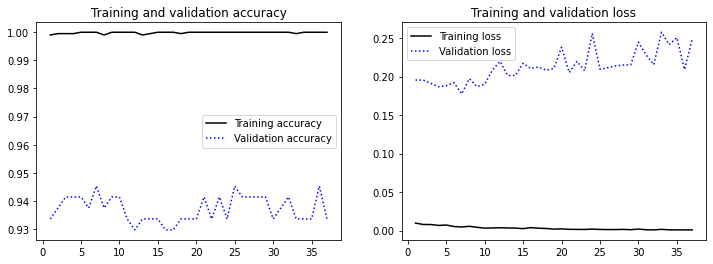

4/4 [==============================] - 0s 6ms/step - loss: 0.2503 - accuracy: 0.9297
TP: 122   FP:  12
FN:   6   TN: 116

              precision    recall  f1-score   support

   pneumonia       0.95      0.91      0.93       128
     healthy       0.91      0.95      0.93       128

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [n + 1 for n in range(len(acc))]
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'k', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss, 'k', label='Training loss')
plt.plot(epochs, val_loss, 'b:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict classes for test images ###
test_score = model.evaluate(
    test_features, 
    test_labels,
    steps= n_test // v_batch_size)

### Get numerical predictions for test set images ###
predictions = model.predict(
    test_features,
    batch_size= n_test // v_batch_size)

### True and predicted labels ###
pred_labels = [1 if p > 0.5 else 0 for p in predictions.ravel()]

### Confusion matrix ###
tn, fp, fn, tp = confusion_matrix(test_labels, pred_labels).ravel()
print("TP: %3i   FP: %3i\nFN: %3i   TN: %3i\n" % (tp, fp, fn, tn))

### Classification metrics ###
print(
    classification_report(
        test_labels,
        pred_labels,
        target_names=['pneumonia', 'healthy']))